# Inicializando

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors
import geopandas as gpd

In [3]:
!pip install kriging
import kriging

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.4/815.4 kB 8.3 MB/s eta 0:00:00


In [4]:
!pip install rasterio
import rasterio
from rasterio.features import shapes
from shapely.geometry import shape

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 51.1 MB/s eta 0:00:00


In [5]:
from rasterio.mask import mask

In [6]:
from shapely.geometry import Point

In [7]:
!pip install contextily
import matplotlib.patches as mpatches
import contextily as ctx

In [8]:
%cd /content/drive/MyDrive/Planeamiento_territorial

/content/drive/MyDrive/Planeamiento_territorial


# Funciones útiles

## Función para graficar la interpolaciónn Kriging básica

El método de interpolación de Kriging en Arcgispro es más "complejo" ya que usa por defecto el método spherical. Como queremos automatizar, usaremos en colab el método de kriging básico.
Revisar documentación de Arcgis pro: https://pro.arcgis.com/es/pro-app/latest/tool-reference/3d-analyst/how-kriging-works.htm

In [9]:
def graficar_kriging_basico(df, lat_col, lon_col, val_col, res=1000, cmap='jet',
                             puntos_muestra=True, shapefile_path=None, xlim=None, ylim=None):
    """
    Parámetros:
    - df: DataFrame de entrada con columnas de coordenadas y valores
    - lat_col: nombre de la columna de latitud
    - lon_col: nombre de la columna de longitud
    - val_col: nombre de la columna con valores a interpolar (puede ser percentil 99, 95, 90 o 75)
    - res: resolución de la malla (default 1000x1000)
    - cmap: mapa de color para la visualización (default 'jet')
    - puntos_muestra: si True, se grafican los puntos de muestra sobre el mapa
    - shapefile_path: si es True, se usara el shapefile de Peru
    - xlim # Longitud (oeste a este) (-71.5, -68.5)
    - ylim # Latitud (sur a norte) (-13.5, -9.5)
    """

    # Extraer coordenadas y valores
    x = df[lon_col].astype(float).values
    y = df[lat_col].astype(float).values
    z = df[val_col].astype(float).values

    # Coordenadas combinadas
    xy = np.c_[x, y]

    # Ajustar modelo Kriging (reemplaza esto con tu implementación si es otra)
    kri = kriging.Kriging()
    kri.fit(xy, z)

    # Crear malla de interpolación
    xls = np.linspace(x.min(), x.max(), res)
    yls = np.linspace(y.min(), y.max(), res)
    xgrid, ygrid = np.meshgrid(xls, yls)

    # Predecir sobre la malla
    zgrid_pred = kri.predict(np.c_[xgrid.ravel(), ygrid.ravel()])
    zgrid = zgrid_pred.reshape(*xgrid.shape)

    zgrid[zgrid < 0] = np.nan #PORQUE ES PP, NO PUEDE SER NEGATIVA
    # Limites solo a partir de los datos
    x_min, x_max = df[lon_col].min(), df[lon_col].max()
    y_min, y_max = df[lat_col].min(), df[lat_col].max()
    aspect_ratio = (y_max - y_min) / (x_max - x_min)
    fig_width = 8
    fig_height = fig_width * aspect_ratio

    plt.figure(figsize=(fig_width, fig_height))
    contour = plt.contourf(xgrid, ygrid, zgrid, cmap=cmap, levels=25)

    if puntos_muestra:
        plt.scatter(x, y, c='k', s=10, label='Puntos de muestra')
        plt.legend()

    if shapefile_path:
        peru = gpd.read_file(shapefile_path)
        peru.plot(ax=plt.gca(), color='none', edgecolor='black')

    if xlim is None:
        xlim = (x_min, x_max)
    if ylim is None:
        ylim = (y_min, y_max)

    plt.xlim(xlim)
    plt.ylim(ylim)

    plt.colorbar(contour, label=val_col)
    plt.title(f'Interpolación Kriging - {val_col}')
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Funcion para clasificar y exportarlo a shapefile

In [11]:
def kriging_clasificado_y_shapefile(df, lat_col, lon_col, val_col, res=1000, output_shapefile='kriging_clasificado.shp'):
    """
    Realiza una interpolación Kriging, clasifica en 4 clases, grafica y exporta a shapefile.

    Parámetros:
    - df: DataFrame con columnas de coordenadas y valores.
    - lat_col: nombre de la columna de latitud.
    - lon_col: nombre de la columna de longitud.
    - val_col: nombre de la columna con los valores a interpolar.
    - res: resolución de la malla (default 1000x1000).
    - output_shapefile: nombre del archivo shapefile de salida.
    """
    # Extraer datos
    x = df[lon_col].astype(float).values
    y = df[lat_col].astype(float).values
    z = df[val_col].astype(float).values
    xy = np.c_[x, y]

    # Ajustar modelo Kriging
    kri = kriging.Kriging()
    kri.fit(xy, z)

    # Crear malla
    xls = np.linspace(x.min(), x.max(), res)
    yls = np.linspace(y.min(), y.max(), res)
    xgrid, ygrid = np.meshgrid(xls, yls)

    # Predicción sobre la malla
    zgrid_pred = kri.predict(np.c_[xgrid.ravel(), ygrid.ravel()])
    zgrid = zgrid_pred.reshape(*xgrid.shape)

    # Clasificación en 4 clases
    z_min, z_max = zgrid.min(), zgrid.max()
    thresholds = np.linspace(z_min, z_max, 5)  # 4 clases = 5 cortes
    labels = ['Bajo', 'Medio', 'Alto', 'Muy Alto']
    z_classes = np.digitize(zgrid, thresholds) - 1
    z_classes = np.clip(z_classes, 0, 3)  # máximo índice = 3 (4 clases)

    # Imprimir los rangos de las clases
    print("Rangos de clases:")
    for i in range(4):
        print(f"{labels[i]}: {thresholds[i]:.2f} a {thresholds[i+1]:.2f}")

    # Visualización
    cmap = mcolors.ListedColormap(['green', 'yellow', 'orange', 'red'])  # 4 colores
    plt.figure(figsize=(8, 6))
    cax = plt.imshow(z_classes, extent=(xls.min(), xls.max(), yls.min(), yls.max()),
                     cmap=cmap, interpolation='none')
    plt.scatter(x, y, c='k', s=5, label='Muestras')
    cbar = plt.colorbar(cax, ticks=np.arange(0.5, 4.5, 1))
    cbar.ax.set_yticklabels(labels)
    plt.title(f'Kriging Clasificado - {val_col}')
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Invertir matriz para exportación correcta (origen arriba a la izquierda)
    z_classes_flipped = np.flipud(z_classes)

    # Exportar a shapefile
    xres = (xls.max() - xls.min()) / res
    yres = (yls.max() - yls.min()) / res
    transform = rasterio.transform.from_origin(xls.min(), yls.max(), xres, yres)

    # Extraer polígonos de las clases
    shape_gen = shapes(z_classes_flipped.astype(np.int16), transform=transform)
    geometries = []
    class_vals = []

    for geom, value in shape_gen:
        if value is None:
            continue
        geometries.append(shape(geom))
        class_vals.append(labels[int(value)])

    # Crear GeoDataFrame
    gdf = gpd.GeoDataFrame({'class': class_vals, 'geometry': geometries}, crs="EPSG:4326")
    gdf = gdf[gdf.is_valid]  # Eliminar geometrías inválidas si hay

    # Guardar shapefile
    gdf.to_file(output_shapefile)
    print(f"\n✅ Shapefile exportado: {output_shapefile}")

## Funcion eliminar

In [12]:
def control_kriging_basico(df, lat_col, lon_col, val_col, res=1000, cmap='jet',
                             puntos_muestra=True, shapefile_path=None, xlim=None, ylim=None):
    """
    Función para graficar la interpolación Kriging y recortar con el shapefile si se desea.
    """
    # Extraer coordenadas y valores
    # Extraer datos
    x = df[lon_col].astype(float).values
    y = df[lat_col].astype(float).values
    z = df[val_col].astype(float).values
    xy = np.c_[x, y]

    # Ajustar Kriging
    kri = kriging.Kriging()
    kri.fit(xy, z)

    # Crear grilla
    xls = np.linspace(x.min(), x.max(), res)
    yls = np.linspace(y.min(), y.max(), res)
    xgrid, ygrid = np.meshgrid(xls, yls)

    # Interpolar
    zgrid_pred = kri.predict(np.c_[xgrid.ravel(), ygrid.ravel()])
    zgrid = zgrid_pred.reshape(*xgrid.shape)
    zgrid[zgrid < 0] = np.nan #PORQUE ES PP, NO PUEDE SER NEGATIVA
    # Si se proporciona shapefile, enmascarar
    if shapefile_path:
        peru = gpd.read_file(shapefile_path)
        puntos = np.c_[xgrid.ravel(), ygrid.ravel()]
        puntos_geom = [Point(xy) for xy in puntos]
        puntos_gdf = gpd.GeoDataFrame(geometry=puntos_geom, crs="EPSG:4326")
        dentro = puntos_gdf.within(peru.unary_union)

        # Aplicar máscara
        zgrid_masked = np.full_like(zgrid, np.nan)
        zgrid_masked.ravel()[dentro] = zgrid.ravel()[dentro]
        zgrid = zgrid_masked

    # Calcular aspecto para buen tamaño
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    aspect_ratio = (y_max - y_min) / (x_max - x_min)
    fig_width = 8
    fig_height = fig_width * aspect_ratio

    # Plot
    plt.figure(figsize=(fig_width, fig_height))
    contour = plt.contourf(xgrid, ygrid, zgrid, cmap=cmap, levels=25)

    if puntos_muestra:
        plt.scatter(x, y, c='k', s=10, label='Puntos de muestra')
        plt.legend()

    if shapefile_path:
        peru.plot(ax=plt.gca(), color='none', edgecolor='black')

    # Límites del gráfico
    if xlim is None:
        xlim = (x_min, x_max)
    if ylim is None:
        ylim = (y_min, y_max)

    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.colorbar(contour, label=val_col)
    plt.title(f'Interpolación Kriging - {val_col}')
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Función clip y exportar

In [13]:
def kriging_clasificado_negativa(df, lat_col, lon_col, val_col, res=1000,
                                  output_shapefile='kriging_clasificado.shp',
                                  shapefile_path=None, xlim=None, ylim=None):
    """
    Realiza interpolación Kriging, clasifica en 4 clases, enmascara negativos y área fuera del shapefile,
    grafica correctamente y exporta shapefile con orientación correcta.
    """
    # Extraer datos
    x = df[lon_col].astype(float).values
    y = df[lat_col].astype(float).values
    z = df[val_col].astype(float).values
    xy = np.c_[x, y]

    # Ajustar modelo Kriging
    kri = kriging.Kriging()
    kri.fit(xy, z)

    # Crear malla
    xls = np.linspace(x.min(), x.max(), res)
    yls = np.linspace(y.min(), y.max(), res)
    xgrid, ygrid = np.meshgrid(xls, yls)

    # Predicción y conversión a float para permitir NaN
    zgrid_pred = kri.predict(np.c_[xgrid.ravel(), ygrid.ravel()])
    zgrid = zgrid_pred.reshape(*xgrid.shape).astype(float)

    # Enmascarar valores negativos
    zgrid[zgrid < 0] = np.nan

    # Enmascarar fuera del shapefile
    if shapefile_path:
        peru = gpd.read_file(shapefile_path)
        puntos = np.c_[xgrid.ravel(), ygrid.ravel()]
        puntos_geom = [Point(xy) for xy in puntos]
        puntos_gdf = gpd.GeoDataFrame(geometry=puntos_geom, crs="EPSG:4326")
        dentro = puntos_gdf.within(peru.unary_union)
        zgrid_masked = np.full_like(zgrid, np.nan)
        zgrid_masked.ravel()[dentro] = zgrid.ravel()[dentro]
        zgrid = zgrid_masked

    # Calcular aspecto para buen tamaño
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    aspect_ratio = (y_max - y_min) / (x_max - x_min)
    fig_width = 8
    fig_height = fig_width * aspect_ratio

    # Clasificación (sin incluir NaN en la clasificación)
    z_min, z_max = np.nanmin(zgrid), np.nanmax(zgrid)
    cmap = mcolors.ListedColormap(['green', 'yellow', 'orange', 'red'])  # 4 colores
    thresholds = np.linspace(z_min, z_max, 5)
    labels = ['Bajo', 'Medio', 'Alto', 'Muy Alto']
    z_classes = np.digitize(zgrid, thresholds) - 1
    z_classes = np.clip(z_classes, 0, 3)

    print("Rangos de clases:")
    for i in range(4):
        print(f"{labels[i]}: {thresholds[i]:.2f} a {thresholds[i+1]:.2f}")

    # Crear la figura
    plt.figure(figsize=(fig_width, fig_height))

    # Límites del gráfico
    if xlim is None:
        xlim = (x_min, x_max)
    if ylim is None:
        ylim = (y_min, y_max)

    plt.xlim(xlim)
    plt.ylim(ylim)

    # Crear máscara para graficar sin NaNs
    masked_z_classes = np.ma.masked_where(np.isnan(zgrid), z_classes)

    # Graficar
    cax = plt.imshow(masked_z_classes, extent=(xls.min(), xls.max(), yls.min(), yls.max()),
                     cmap=cmap, interpolation='none', origin='lower')

    cbar = plt.colorbar(cax, ticks=np.arange(0.5, 4.5, 1))
    cbar.ax.set_yticklabels(labels)
    plt.title(f'Kriging Clasificado - {val_col}')
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')

    if shapefile_path:
        peru.plot(ax=plt.gca(), color='none', edgecolor='black')

    for i, label in enumerate(labels):
        plt.scatter([], [], c=cmap(i / 4), label=label, edgecolors='k', s=100)

    plt.legend(title='Clases', loc='upper right', fontsize=9)
    plt.grid(True)
    plt.show()

    # Preparar para exportar: invertir matriz para orientación correcta
    masked_z_classes_flipped = np.flipud(masked_z_classes)

    # Calcular transformada espacial
    xres = (xls.max() - xls.min()) / res
    yres = (yls.max() - yls.min()) / res
    transform = rasterio.transform.from_origin(xls.min(), yls.max(), xres, yres)

    # Crear geometrías
    shape_gen = shapes(masked_z_classes_flipped.astype(np.int16), transform=transform)
    geometries = []
    class_vals = []

    for geom, value in shape_gen:
        if value is None:
            continue
        geometries.append(shape(geom))
        class_vals.append(labels[int(value)])

    # Crear GeoDataFrame
    gdf = gpd.GeoDataFrame({'class': class_vals, 'geometry': geometries}, crs="EPSG:4326")
    gdf = gdf[gdf.is_valid]  # Filtrar geom. inválidas
    gdf.to_file(output_shapefile)

    print(f"\n✅ Shapefile exportado: {output_shapefile}")


# Accediendo archivos

In [14]:
ruta_Madre_Dios = "Planeamiento_archivos/PP.csv"
df_Madre_Dios = pd.read_csv(ruta_Madre_Dios, sep=";")
df_Madre_Dios = df_Madre_Dios.dropna(axis=1, how='all')
df_Madre_Dios = df_Madre_Dios.dropna(axis=0, how='all')
df_Madre_Dios.tail()

Longitud   Latitud    P99    P95    P90    P75
64      -69.7   -13.75  488.5  434.3  401.4  265.0
65      -69.2   -13.75  397.0  331.3  277.0  186.3
66      -68.7   -13.75  357.9  339.0  290.4  210.9
67      -68.2   -13.75  343.1  312.3  281.1  193.2
68      -68.2   -14.25  343.4  276.6  253.2  173.3

In [15]:
df_Madre_Dios.columns = df_Madre_Dios.columns.str.strip()

In [16]:
df_Madre_Dios.columns

Index(['Longitud', 'Latitud', 'P99', 'P95', 'P90', 'P75'], dtype='object')

In [17]:
ruta_Peru = "Planeamiento_archivos/Percentiles.xlsx"
df_Peru = pd.read_excel(ruta_Peru, sheet_name=2)
df_Peru.tail()

Lon    Lat      P99      P95     P90      P75
1295 -67.2 -19.75  177.595   85.290  63.505  22.8250
1296 -66.7 -19.75  126.825   74.525  48.745  15.5875
1297 -66.2 -19.75  105.595   70.140  52.075  21.9025
1298 -65.7 -19.75  144.545  104.425  82.950  45.2775
1299 -65.2 -19.75  165.545  118.500  95.890  58.4800

<Axes: >

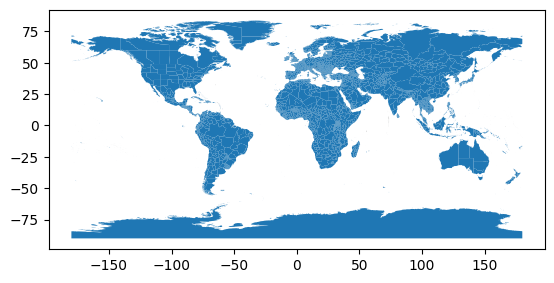

In [18]:
ruta_limites = "Planeamiento_archivos/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp"
shape_limites = gpd.read_file(ruta_limites)
shape_limites.plot()

<Axes: >

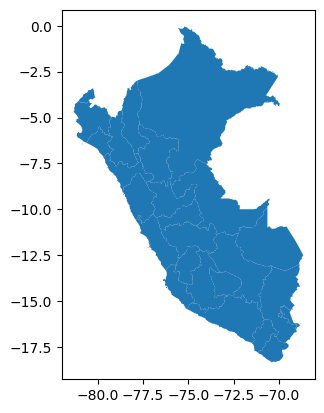

In [19]:
ruta_limites_Peru = "Planeamiento_archivos/SHPCensoDepartamento INEI 2007 geogpsperu SuyoPomalia/SHPCensoDepartamento INEI 2007 geogpsperu SuyoPomalia.shp"
shape_limites_Peru = gpd.read_file(ruta_limites_Peru)
shape_limites_Peru.plot()

# Interpolación Madre de Dios

In [20]:
df_Madre_Dios.columns

Index(['Longitud', 'Latitud', 'P99', 'P95', 'P90', 'P75'], dtype='object')

In [21]:
plt.figure(figsize=(6, 5))
cax = plt.scatter(df_Madre_Dios["Longitud"], df_Madre_Dios["Latitud"], c=df_Madre_Dios["P99"], cmap='viridis')
plt.colorbar(cax, fraction=0.03)
plt.title('Puntos - Percentil 99 de Precipitación')
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.grid(True)
plt.show()

## Interpolaciones

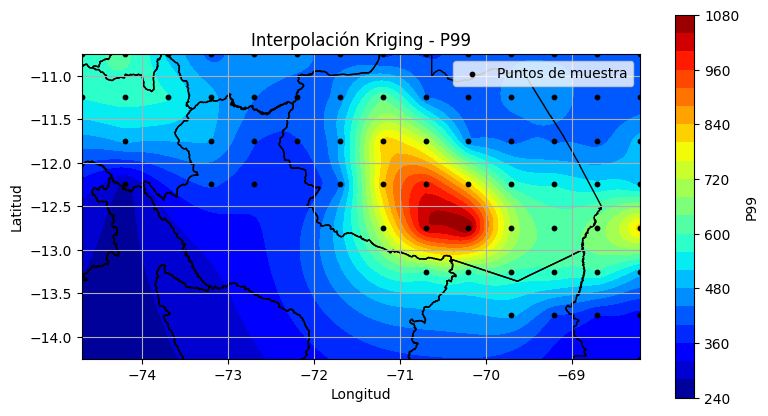

In [22]:
graficar_kriging_basico(df_Madre_Dios, "Latitud", "Longitud", "P99", res=100, cmap='jet', puntos_muestra=True,
                           shapefile_path=ruta_limites_Peru, xlim=None, ylim=None)

In [ ]:
graficar_kriging_basico(df_Madre_Dios, "Latitud", "Longitud", "P99", res=100, cmap='jet', puntos_muestra=False,
                           shapefile_path=ruta_limites_Peru, xlim=(-75,-68), ylim=(-14.5,-10))

In [23]:
graficar_kriging_basico(df_Madre_Dios, "Latitud", "Longitud", "P95", res=100, cmap='jet', puntos_muestra=False,
                           shapefile_path=ruta_limites_Peru, xlim=(-75,-68), ylim=(-14.5,-10))

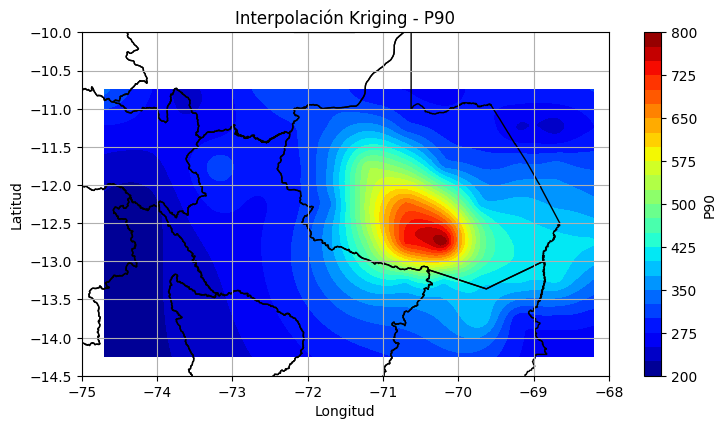

In [24]:
graficar_kriging_basico(df_Madre_Dios, "Latitud", "Longitud", "P90", res=100, cmap='jet', puntos_muestra=False,
                           shapefile_path=ruta_limites_Peru, xlim=(-75,-68), ylim=(-14.5,-10))

In [25]:
graficar_kriging_basico(df_Madre_Dios, "Latitud", "Longitud", "P75", res=100, cmap='jet', puntos_muestra=False,
                           shapefile_path=ruta_limites_Peru, xlim=(-75,-68), ylim=(-14.5,-10))

## Clasificando y exportando a shapefile

In [39]:
!mkdir /content/drive/MyDrive/Planeamiento_territorial/shapefile_Madre_Dios

mkdir: cannot create directory ‘/content/drive/MyDrive/Planeamiento_territorial/shapefile_Madre_Dios’: File exists


In [40]:
!mkdir /content/drive/MyDrive/Planeamiento_territorial/shapefile_Madre_Dios/p99

mkdir: cannot create directory ‘/content/drive/MyDrive/Planeamiento_territorial/shapefile_Madre_Dios/p99’: File exists


In [41]:
kriging_clasificado_y_shapefile(
    df=df_Madre_Dios,
    lat_col="Latitud",
    lon_col="Longitud",
    val_col="P99",
    res=1000,
    output_shapefile="shapefile_Madre_Dios/p99/madre_dios_p99.shp"
)

Rangos de clases:
Bajo: 269.05 a 472.44
Medio: 472.44 a 675.82
Alto: 675.82 a 879.21
Muy Alto: 879.21 a 1082.60



✅ Shapefile exportado: shapefile_Madre_Dios/p99/madre_dios_p99.shp


In [42]:
!mkdir /content/drive/MyDrive/Planeamiento_territorial/shapefile_Madre_Dios/p95

mkdir: cannot create directory ‘/content/drive/MyDrive/Planeamiento_territorial/shapefile_Madre_Dios/p95’: File exists


Rangos de clases:
Bajo: 230.62 a 388.37
Medio: 388.37 a 546.11
Alto: 546.11 a 703.85
Muy Alto: 703.85 a 861.59


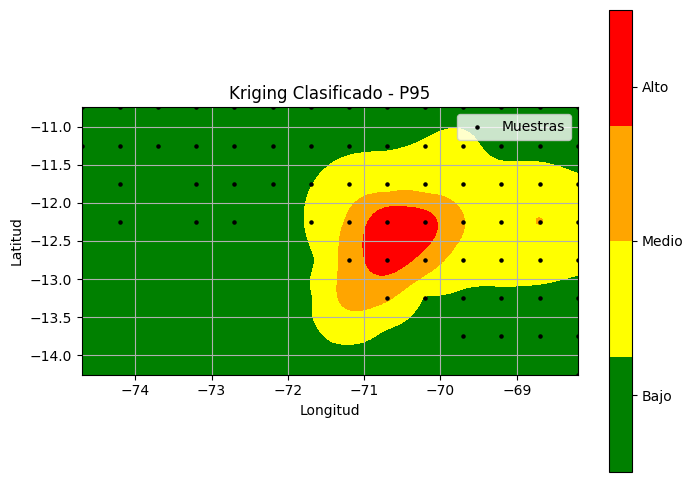


✅ Shapefile exportado: shapefile_Madre_Dios/p95/madre_dios_p95.shp


In [43]:
kriging_clasificado_y_shapefile(
    df=df_Madre_Dios,
    lat_col="Latitud",
    lon_col="Longitud",
    val_col="P95",
    res=1000,
    output_shapefile="shapefile_Madre_Dios/p95/madre_dios_p95.shp"
)

In [44]:
!mkdir /content/drive/MyDrive/Planeamiento_territorial/shapefile_Madre_Dios/p90

mkdir: cannot create directory ‘/content/drive/MyDrive/Planeamiento_territorial/shapefile_Madre_Dios/p90’: File exists


Rangos de clases:
Bajo: 205.11 a 355.01
Medio: 355.01 a 504.91
Alto: 504.91 a 654.82
Muy Alto: 654.82 a 804.72


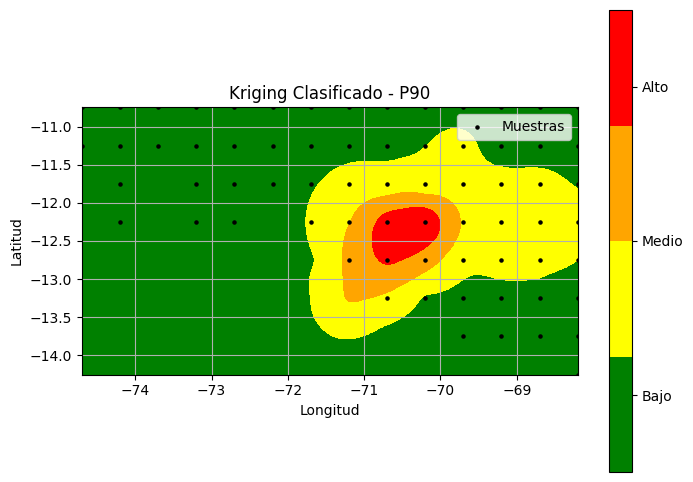


✅ Shapefile exportado: shapefile_Madre_Dios/p90/madre_dios_p90.shp


In [45]:
kriging_clasificado_y_shapefile(
    df=df_Madre_Dios,
    lat_col="Latitud",
    lon_col="Longitud",
    val_col="P90",
    res=1000,
    output_shapefile="shapefile_Madre_Dios/p90/madre_dios_p90.shp"
)

In [46]:
!mkdir /content/drive/MyDrive/Planeamiento_territorial/shapefile_Madre_Dios/p75

mkdir: cannot create directory ‘/content/drive/MyDrive/Planeamiento_territorial/shapefile_Madre_Dios/p75’: File exists


Rangos de clases:
Bajo: 150.79 a 265.74
Medio: 265.74 a 380.68
Alto: 380.68 a 495.62
Muy Alto: 495.62 a 610.57


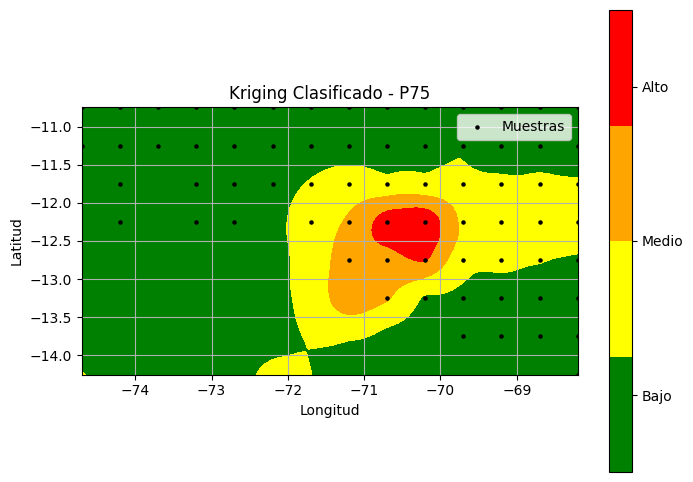


✅ Shapefile exportado: shapefile_Madre_Dios/p75/madre_dios_p75.shp


In [47]:
kriging_clasificado_y_shapefile(
    df=df_Madre_Dios,
    lat_col="Latitud",
    lon_col="Longitud",
    val_col="P75",
    res=1000,
    output_shapefile="shapefile_Madre_Dios/p75/madre_dios_p75.shp"
)

# Interpolación todo Peru

In [48]:
df_Peru.columns

Index(['Lon', 'Lat', 'P99', 'P95', 'P90', 'P75'], dtype='object')

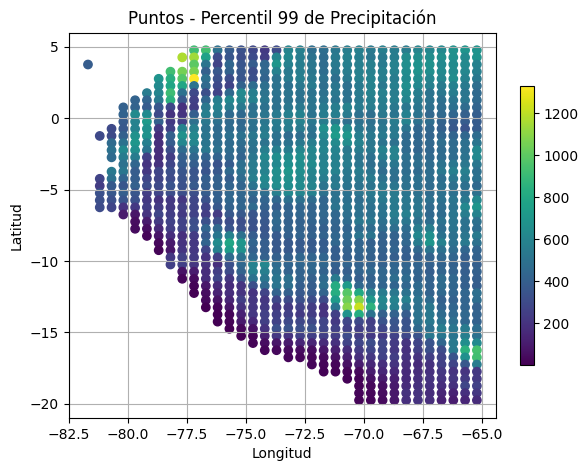

In [49]:
plt.figure(figsize=(6, 5))
cax = plt.scatter(df_Peru["Lon"], df_Peru["Lat"], c=df_Peru["P99"], cmap='viridis')
plt.colorbar(cax, fraction=0.03)
plt.title('Puntos - Percentil 99 de Precipitación')
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.grid(True)
plt.show()

## Interpolaciones

In [50]:
graficar_kriging_basico(df_Peru, "Lat", "Lon", "P99", res=100, cmap='jet', puntos_muestra=False,
                           shapefile_path=ruta_limites, xlim=(-83,-65), ylim=(-20.5,5.5))

In [51]:
graficar_kriging_basico(df_Peru, "Lat", "Lon", "P95", res=100, cmap='jet', puntos_muestra=False,
                           shapefile_path=ruta_limites, xlim=(-83,-65), ylim=(-20.5,5.5))

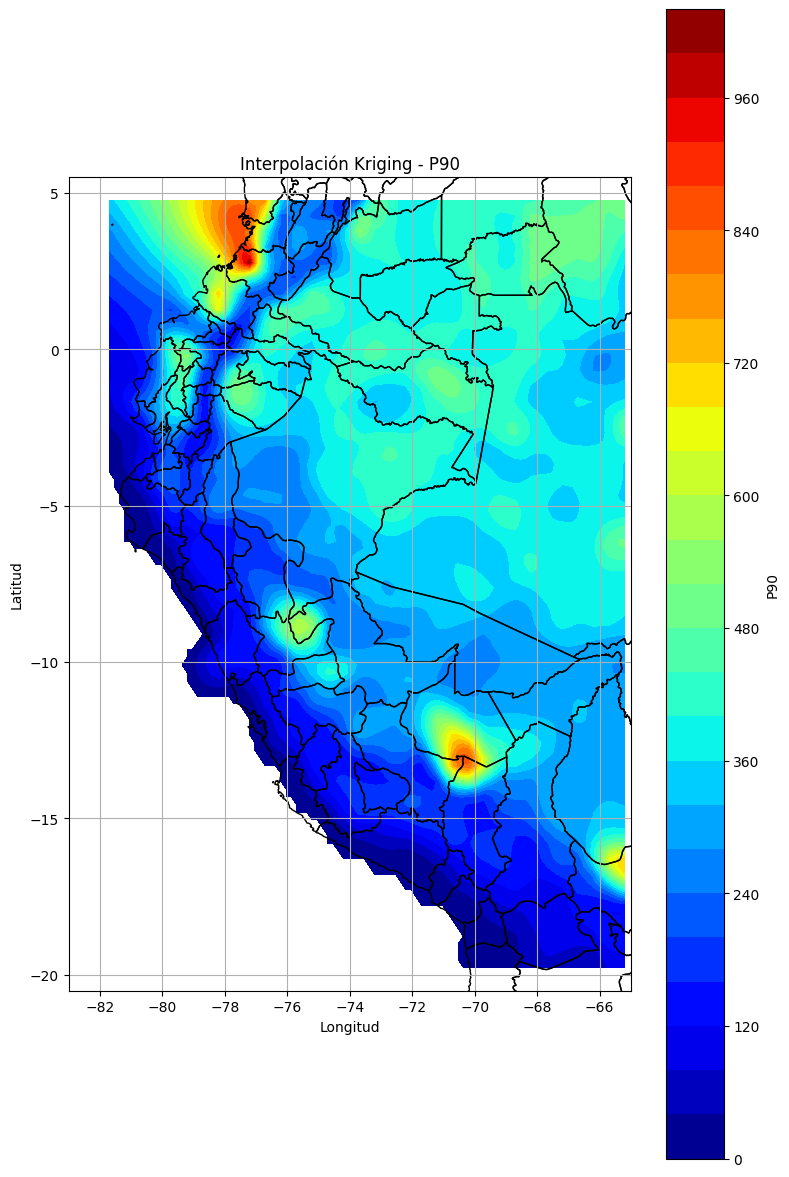

In [52]:
graficar_kriging_basico(df_Peru, "Lat", "Lon", "P90", res=100, cmap='jet', puntos_muestra=False,
                           shapefile_path=ruta_limites, xlim=(-83,-65), ylim=(-20.5,5.5))

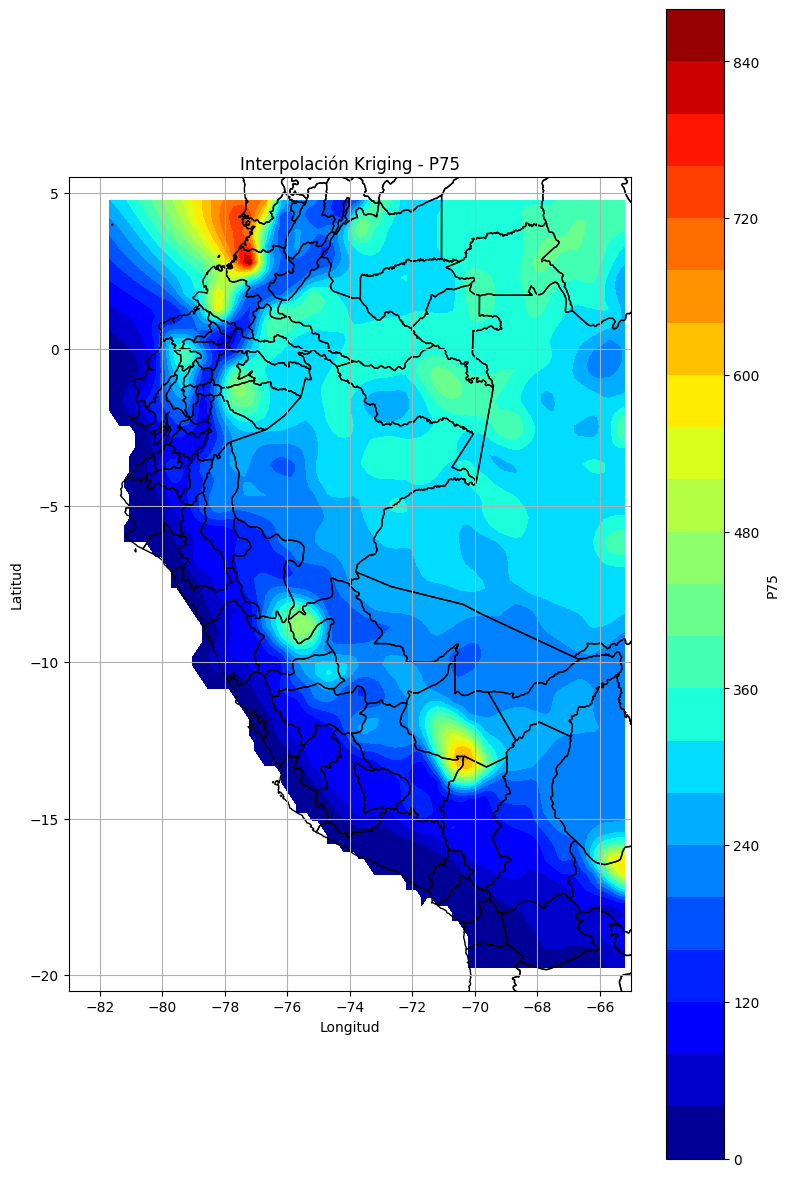

In [53]:
graficar_kriging_basico(df_Peru, "Lat", "Lon", "P75", res=100, cmap='jet', puntos_muestra=False,
                           shapefile_path=ruta_limites, xlim=(-83,-65), ylim=(-20.5,5.5))

## Eliminando valores negativos

In [54]:
control_kriging_basico(df_Peru, "Lat", "Lon", "P99", res=100, cmap='jet', puntos_muestra=False,
                           shapefile_path=ruta_limites, xlim=(-83,-65), ylim=(-20.5,5.5))

<ipython-input-12-f3a85af535c5>:32: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  dentro = puntos_gdf.within(peru.unary_union)


In [55]:
control_kriging_basico(df_Peru, "Lat", "Lon", "P95", res=100, cmap='jet', puntos_muestra=False,
                           shapefile_path=ruta_limites, xlim=(-83,-65), ylim=(-20.5,5.5))

<ipython-input-12-f3a85af535c5>:32: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  dentro = puntos_gdf.within(peru.unary_union)


In [56]:
control_kriging_basico(df_Peru, "Lat", "Lon", "P90", res=100, cmap='jet', puntos_muestra=False,
                           shapefile_path=ruta_limites, xlim=(-83,-65), ylim=(-20.5,5.5))

<ipython-input-12-f3a85af535c5>:32: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  dentro = puntos_gdf.within(peru.unary_union)


<ipython-input-12-f3a85af535c5>:32: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  dentro = puntos_gdf.within(peru.unary_union)


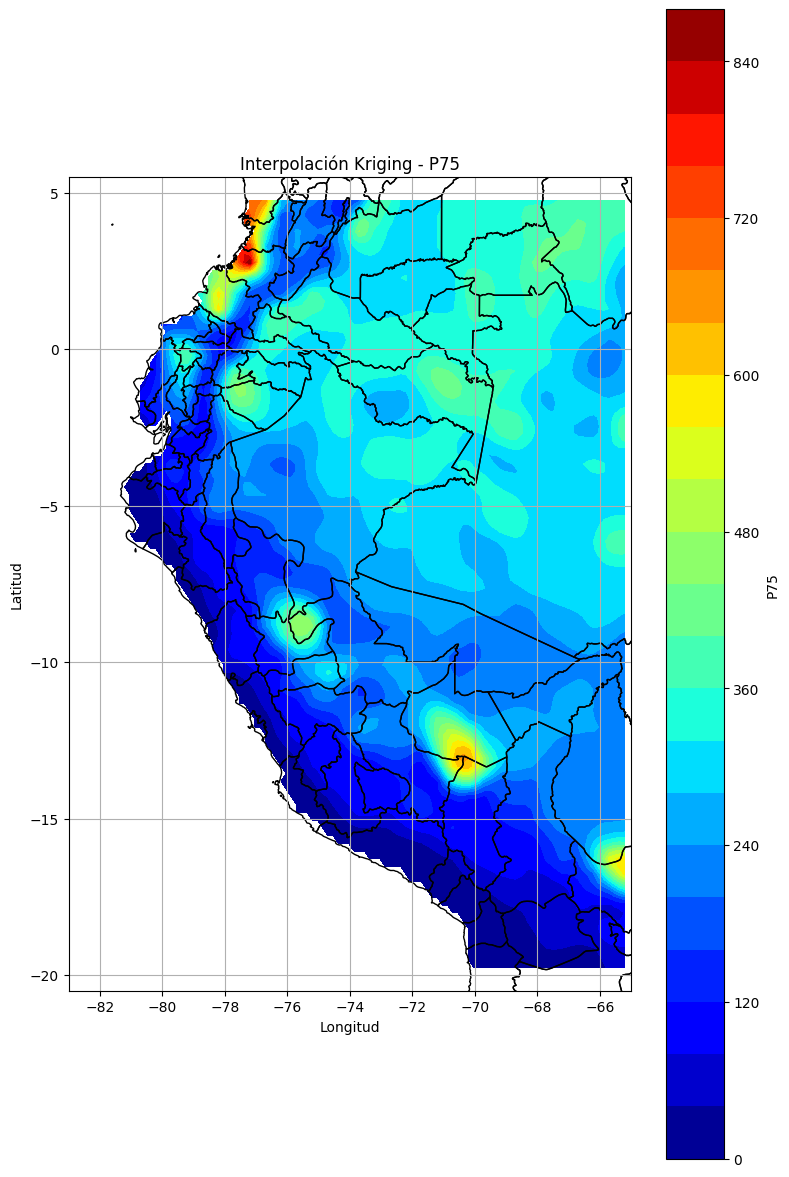

In [57]:
control_kriging_basico(df_Peru, "Lat", "Lon", "P75", res=100, cmap='jet', puntos_muestra=False,
                           shapefile_path=ruta_limites, xlim=(-83,-65), ylim=(-20.5,5.5))

## Clasificacion

In [58]:
!mkdir /content/drive/MyDrive/Planeamiento_territorial/shapefile_Peru

mkdir: cannot create directory ‘/content/drive/MyDrive/Planeamiento_territorial/shapefile_Peru’: File exists


In [59]:
!mkdir /content/drive/MyDrive/Planeamiento_territorial/shapefile_Peru/p99

mkdir: cannot create directory ‘/content/drive/MyDrive/Planeamiento_territorial/shapefile_Peru/p99’: File exists


<ipython-input-13-2ffc6b008c23>:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  dentro = puntos_gdf.within(peru.unary_union)


Rangos de clases:
Bajo: 1.76 a 328.91
Medio: 328.91 a 656.06
Alto: 656.06 a 983.21
Muy Alto: 983.21 a 1310.36


<ipython-input-13-2ffc6b008c23>:89: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=cmap(i / 4), label=label, edgecolors='k', s=100)


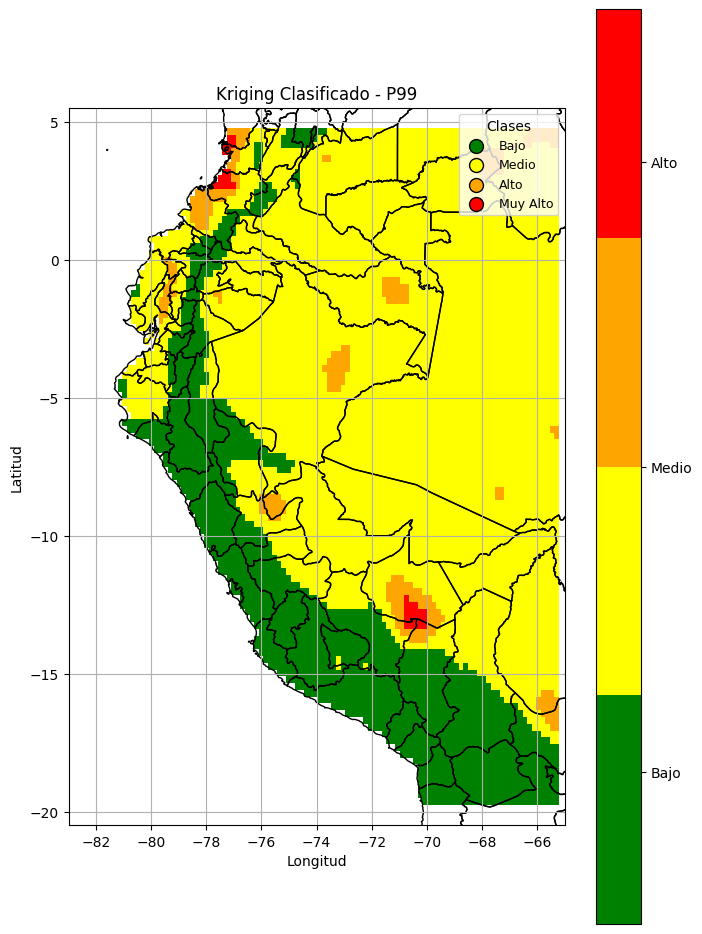


✅ Shapefile exportado: shapefile_Peru/p99/peru_p99.shp


In [60]:
kriging_clasificado_negativa(
    df=df_Peru,
    lat_col="Lat",
    lon_col="Lon",
    val_col="P99",
    res=100,
    output_shapefile="shapefile_Peru/p99/peru_p99.shp",
    shapefile_path=ruta_limites,
    xlim=(-83,-65), ylim=(-20.5,5.5))

In [61]:
!mkdir /content/drive/MyDrive/Planeamiento_territorial/shapefile_Peru/p95

mkdir: cannot create directory ‘/content/drive/MyDrive/Planeamiento_territorial/shapefile_Peru/p95’: File exists


<ipython-input-13-2ffc6b008c23>:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  dentro = puntos_gdf.within(peru.unary_union)


Rangos de clases:
Bajo: 0.44 a 290.60
Medio: 290.60 a 580.76
Alto: 580.76 a 870.92
Muy Alto: 870.92 a 1161.07


<ipython-input-13-2ffc6b008c23>:89: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=cmap(i / 4), label=label, edgecolors='k', s=100)


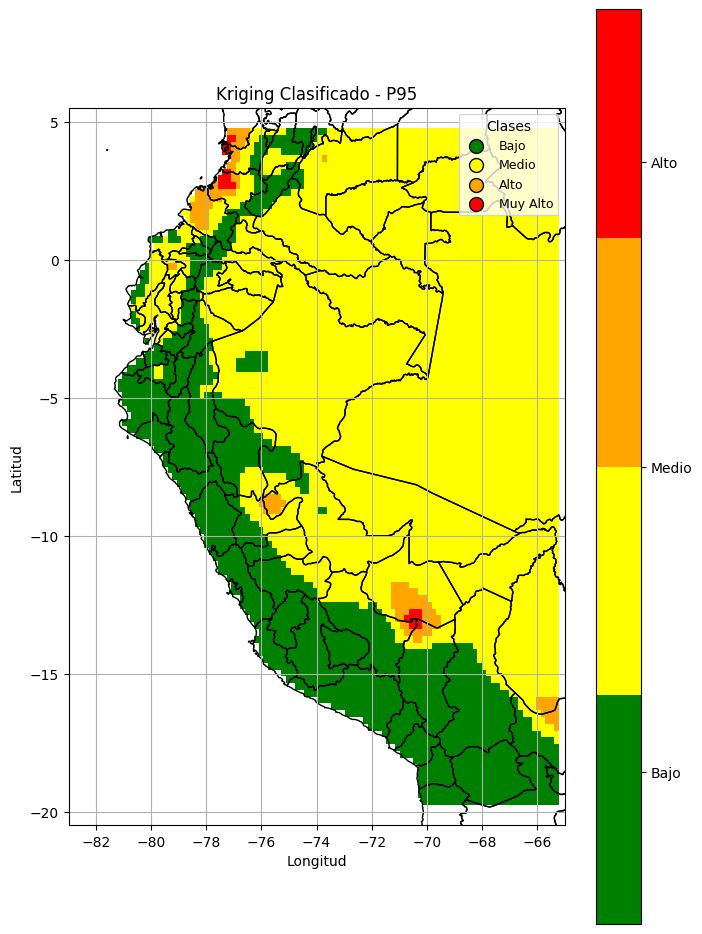


✅ Shapefile exportado: shapefile_Peru/p95/peru_p95.shp


In [62]:
kriging_clasificado_negativa(
    df=df_Peru,
    lat_col="Lat",
    lon_col="Lon",
    val_col="P95",
    res=100,
    output_shapefile="shapefile_Peru/p95/peru_p95.shp",
    shapefile_path=ruta_limites,
    xlim=(-83,-65), ylim=(-20.5,5.5))

In [63]:
!mkdir /content/drive/MyDrive/Planeamiento_territorial/shapefile_Peru/p90

mkdir: cannot create directory ‘/content/drive/MyDrive/Planeamiento_territorial/shapefile_Peru/p90’: File exists


<ipython-input-13-2ffc6b008c23>:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  dentro = puntos_gdf.within(peru.unary_union)


Rangos de clases:
Bajo: 0.35 a 254.90
Medio: 254.90 a 509.45
Alto: 509.45 a 764.00
Muy Alto: 764.00 a 1018.55


<ipython-input-13-2ffc6b008c23>:89: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=cmap(i / 4), label=label, edgecolors='k', s=100)


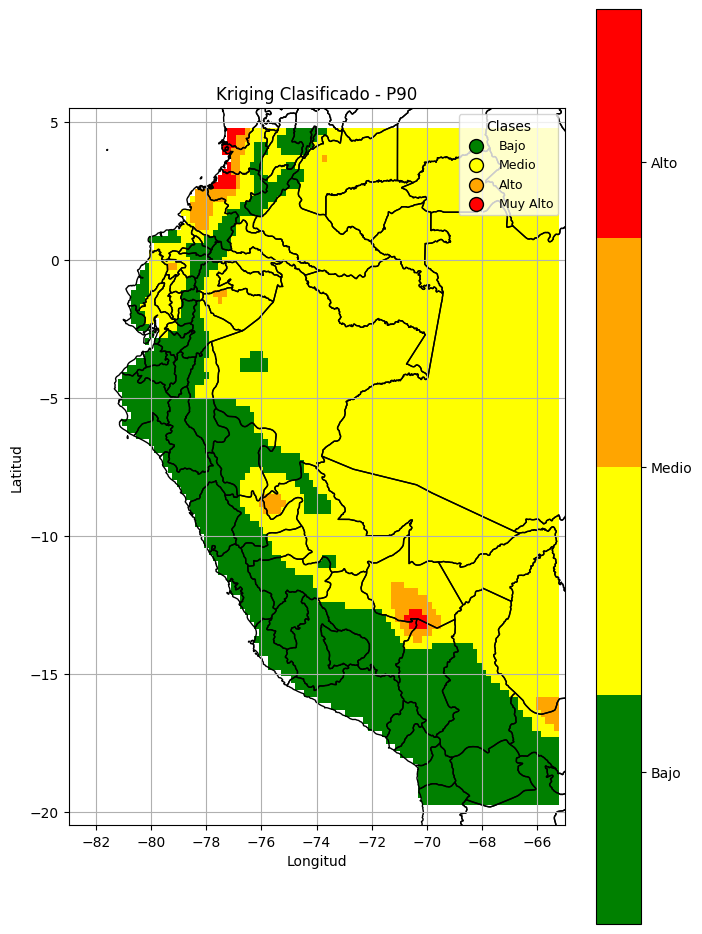


✅ Shapefile exportado: shapefile_Peru/p90/peru_p90.shp


In [64]:
kriging_clasificado_negativa(
    df=df_Peru,
    lat_col="Lat",
    lon_col="Lon",
    val_col="P90",
    res=100,
    output_shapefile="shapefile_Peru/p90/peru_p90.shp",
    shapefile_path=ruta_limites,
    xlim=(-83,-65), ylim=(-20.5,5.5))

In [65]:
!mkdir /content/drive/MyDrive/Planeamiento_territorial/shapefile_Peru/p75

mkdir: cannot create directory ‘/content/drive/MyDrive/Planeamiento_territorial/shapefile_Peru/p75’: File exists


In [66]:
kriging_clasificado_negativa(
    df=df_Peru,
    lat_col="Lat",
    lon_col="Lon",
    val_col="P75",
    res=100,
    output_shapefile="shapefile_Peru/p75/peru_p75.shp",
    shapefile_path=ruta_limites,
    xlim=(-83,-65), ylim=(-20.5,5.5))

<ipython-input-13-2ffc6b008c23>:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  dentro = puntos_gdf.within(peru.unary_union)


Rangos de clases:
Bajo: 0.01 a 219.41
Medio: 219.41 a 438.80
Alto: 438.80 a 658.19
Muy Alto: 658.19 a 877.58


<ipython-input-13-2ffc6b008c23>:89: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=cmap(i / 4), label=label, edgecolors='k', s=100)



✅ Shapefile exportado: shapefile_Peru/p75/peru_p75.shp


# Peligro y Vulnerabilidad

In [67]:
peligro_p99 = gpd.read_file("shapefile_Peru/p99/peru_p99.shp")
peligro_p99.head()

class                                           geometry
0      Bajo  POLYGON ((-75.1 4.75, -73.615 4.75, -73.615 4....
1      Alto  POLYGON ((-66.355 4.75, -65.2 4.75, -65.2 4.01...
2      Alto  POLYGON ((-66.85 4.26, -66.685 4.26, -66.685 4...
3  Muy Alto  POLYGON ((-77.245 4.505, -76.915 4.505, -76.91...
4      Alto  POLYGON ((-73.78 3.77, -73.45 3.77, -73.45 3.5...

In [68]:
def ponderacion_peligro(clase):
    if clase=="Muy Alto":
        return 0.434
    elif clase=="Alto":
        return 0.261
    elif clase=="Medio":
        return 0.155
    elif clase=="Bajo":
        return 0.091
    else:
        return 0

In [69]:
peligro_p99["Valor_peligro"] = peligro_p99["class"].apply(ponderacion_peligro)
peligro_p99.head()

class                                           geometry  Valor_peligro
0      Bajo  POLYGON ((-75.1 4.75, -73.615 4.75, -73.615 4....          0.091
1      Alto  POLYGON ((-66.355 4.75, -65.2 4.75, -65.2 4.01...          0.261
2      Alto  POLYGON ((-66.85 4.26, -66.685 4.26, -66.685 4...          0.261
3  Muy Alto  POLYGON ((-77.245 4.505, -76.915 4.505, -76.91...          0.434
4      Alto  POLYGON ((-73.78 3.77, -73.45 3.77, -73.45 3.5...          0.261

In [70]:
peligro_p99.describe()

Valor_peligro
count      29.000000
mean        0.225448
std         0.100483
min         0.091000
25%         0.155000
50%         0.261000
75%         0.261000
max         0.434000

In [71]:
vulnerabilidad = gpd.read_file("/content/drive/MyDrive/Planeamiento_territorial/Planeamiento_archivos/Vulnerabilidad Fisica Cenepred GEOGPSPERU SuyoPomalia/vulnerabilidad_fisica_cenepred_geogpsperu_SuyoPomalia.shp")
vulnerabilidad.head()

valor descripcio                 contacto           descargar  \
0  2.671834       Alta  Juan Pablo Suyo Pomalía  www.geogpsperu.com   
1  2.949944       Alta  Juan Pablo Suyo Pomalía  www.geogpsperu.com   
2  2.627253       Alta  Juan Pablo Suyo Pomalía  www.geogpsperu.com   
3  2.831166       Alta  Juan Pablo Suyo Pomalía  www.geogpsperu.com   
4  2.627253       Alta  Juan Pablo Suyo Pomalía  www.geogpsperu.com   

    whatsapp                                           geometry  
0  931381206  POLYGON ((312432.634 8906372.715, 312320.39 89...  
1  931381206  POLYGON ((312241.159 8910002.3, 312082.051 891...  
2  931381206  POLYGON ((308668.787 8912951.456, 308731.375 8...  
3  931381206  POLYGON ((305996.254 8942629.651, 306156.323 8...  
4  931381206  POLYGON ((313073.678 8911238.546, 313011.062 8...

In [72]:
vulnerabilidad = vulnerabilidad.to_crs(epsg=4326)
vulnerabilidad.describe()

valor
count  52592.000000
mean       2.774335
std        0.624754
min        0.000000
25%        2.521469
50%        2.900723
75%        3.202658
max        4.000000

<Axes: >

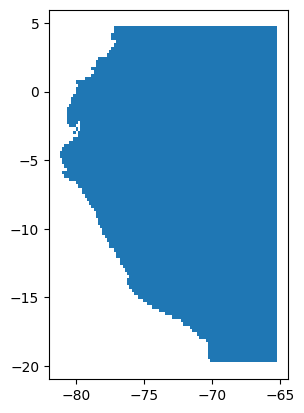

In [73]:
peligro_p99.plot()

<Axes: >

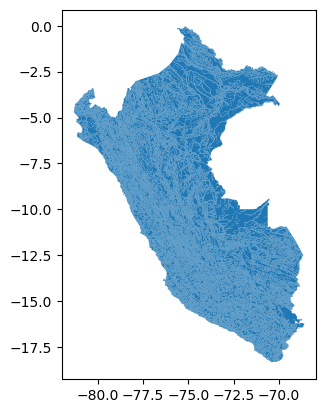

In [74]:
vulnerabilidad.plot()

In [75]:
print(peligro_p99.crs)
print(vulnerabilidad.crs)

EPSG:4326
EPSG:4326


In [76]:
riesgo_shape = gpd.overlay(peligro_p99, vulnerabilidad, how='intersection')
riesgo_shape

class  Valor_peligro     valor descripcio                 contacto  \
0      Alto          0.261  3.281341   Muy alta  Juan Pablo Suyo Pomalía   
1      Alto          0.261  3.281341   Muy alta  Juan Pablo Suyo Pomalía   
2      Alto          0.261  3.281341   Muy alta  Juan Pablo Suyo Pomalía   
3      Alto          0.261  1.668510       Baja  Juan Pablo Suyo Pomalía   
4      Alto          0.261  2.033937       Baja  Juan Pablo Suyo Pomalía   
...     ...            ...       ...        ...                      ...   
53023  Bajo          0.091  2.583417   Moderada  Juan Pablo Suyo Pomalía   
53024  Bajo          0.091  0.000000       None  Juan Pablo Suyo Pomalía   
53025  Bajo          0.091  0.000000       None  Juan Pablo Suyo Pomalía   
53026  Bajo          0.091  0.000000       None  Juan Pablo Suyo Pomalía   
53027  Bajo          0.091  0.000000       None  Juan Pablo Suyo Pomalía   

                descargar   whatsapp  \
0      www.geogpsperu.com  931381206   
1      www.geogpsperu.com  931381206   
2      www.geogpsperu.com  931381206   
3      www.geogpsperu.com  931381206   
4      www.geogpsperu.com  931381206   
...                   ...        ...   
53023  www.geogpsperu.com  931381206   
53024  www.geogpsperu.com  931381206   
53025  www.geogpsperu.com  931381206   
53026  www.geogpsperu.com  931381206   
53027  www.geogpsperu.com  931381206   

                                                geometry  
0      POLYGON ((-73.18094 -3.87527, -73.18178 -3.873...  
1      POLYGON ((-73.20502 -3.9401, -73.2055 -3.9407,...  
2      POLYGON ((-73.29919 -3.87883, -73.30017 -3.880...  
3      POLYGON ((-73.17834 -4.28051, -73.17804 -4.282...  
4      POLYGON ((-73.18835 -4.2393, -73.18991 -4.2381...  
...                                                  ...  
53023  POLYGON ((-74.935 -7.71249, -74.93512 -7.71325...  
53024  POLYGON ((-78.235 -4.77334, -78.23608 -4.7738,...  
53025  POLYGON ((-74.9359 -7.51241, -74.93624 -7.5123...  
53026  POLYGON ((-74.935 -7.54221, -74.93604 -7.54322...  
53027  POLYGON ((-74.935 -7.5556, -74.93515 -7.55566,...  

[53028 rows x 8 columns]

In [77]:
riesgo_shape["Riesgo"] = riesgo_shape["Valor_peligro"]*riesgo_shape["valor"]
riesgo_shape.head()

class  Valor_peligro     valor descripcio                 contacto  \
0  Alto          0.261  3.281341   Muy alta  Juan Pablo Suyo Pomalía   
1  Alto          0.261  3.281341   Muy alta  Juan Pablo Suyo Pomalía   
2  Alto          0.261  3.281341   Muy alta  Juan Pablo Suyo Pomalía   
3  Alto          0.261  1.668510       Baja  Juan Pablo Suyo Pomalía   
4  Alto          0.261  2.033937       Baja  Juan Pablo Suyo Pomalía   

            descargar   whatsapp  \
0  www.geogpsperu.com  931381206   
1  www.geogpsperu.com  931381206   
2  www.geogpsperu.com  931381206   
3  www.geogpsperu.com  931381206   
4  www.geogpsperu.com  931381206   

                                            geometry    Riesgo  
0  POLYGON ((-73.18094 -3.87527, -73.18178 -3.873...  0.856430  
1  POLYGON ((-73.20502 -3.9401, -73.2055 -3.9407,...  0.856430  
2  POLYGON ((-73.29919 -3.87883, -73.30017 -3.880...  0.856430  
3  POLYGON ((-73.17834 -4.28051, -73.17804 -4.282...  0.435481  
4  POLYGON ((-73.18835 -4.2393, -73.18991 -4.2381...  0.530858

In [78]:
riesgo_shape.describe()

Valor_peligro         valor        Riesgo
count   53028.000000  53028.000000  53028.000000
mean        0.123152      2.778973      0.342904
std         0.048654      0.624733      0.161938
min         0.091000      0.000000      0.000000
25%         0.091000      2.521469      0.249110
50%         0.091000      2.949944      0.291442
75%         0.155000      3.202658      0.431509
max         0.434000      4.000000      1.736000

In [79]:
def clasificar_riesgo(riesgo):
    if 0.75 <= riesgo <= 1.75:
        return "MUY ALTA"
    elif 0.43 <= riesgo < 0.75:
        return "ALTA"
    elif 0.29 <= riesgo < 0.43:
        return "MEDIA"
    elif 0 <= riesgo < 0.29:
        return "BAJA"
    else:
        return "OTRO"

In [80]:
riesgo_shape["Nivel Riesgo"] = riesgo_shape["Riesgo"].apply(clasificar_riesgo)
riesgo_shape.head()

class  Valor_peligro     valor descripcio                 contacto  \
0  Alto          0.261  3.281341   Muy alta  Juan Pablo Suyo Pomalía   
1  Alto          0.261  3.281341   Muy alta  Juan Pablo Suyo Pomalía   
2  Alto          0.261  3.281341   Muy alta  Juan Pablo Suyo Pomalía   
3  Alto          0.261  1.668510       Baja  Juan Pablo Suyo Pomalía   
4  Alto          0.261  2.033937       Baja  Juan Pablo Suyo Pomalía   

            descargar   whatsapp  \
0  www.geogpsperu.com  931381206   
1  www.geogpsperu.com  931381206   
2  www.geogpsperu.com  931381206   
3  www.geogpsperu.com  931381206   
4  www.geogpsperu.com  931381206   

                                            geometry    Riesgo Nivel Riesgo  
0  POLYGON ((-73.18094 -3.87527, -73.18178 -3.873...  0.856430     MUY ALTA  
1  POLYGON ((-73.20502 -3.9401, -73.2055 -3.9407,...  0.856430     MUY ALTA  
2  POLYGON ((-73.29919 -3.87883, -73.30017 -3.880...  0.856430     MUY ALTA  
3  POLYGON ((-73.17834 -4.28051, -73.17804 -4.282...  0.435481         ALTA  
4  POLYGON ((-73.18835 -4.2393, -73.18991 -4.2381...  0.530858         ALTA

In [81]:
riesgo_shape["Nivel Riesgo"].unique()

array(['MUY ALTA', 'ALTA', 'BAJA', 'MEDIA'], dtype=object)

In [85]:
fig, ax = plt.subplots(figsize=(10, 10))

colores = {'MUY ALTA': 'red', 'ALTA': 'orange', 'MEDIA': 'yellow','BAJA': 'green', 'OTRO': 'gray'}

# Graficar el GeoDataFrame con colores según el nivel de vulnerabilidad
riesgo_shape['color'] = riesgo_shape['Nivel Riesgo'].map(colores)
riesgo_shape.plot(ax=ax, color=riesgo_shape['color'])
shape_limites_Peru.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)
# Crear una leyenda personalizada
handles = [mpatches.Patch(color=color, label=level) for level, color in colores.items()]
ax.legend(handles=handles, title='Nivel de Riesgo', loc='upper right')
ctx.add_basemap(ax, crs=shape_limites_Peru.crs, source=ctx.providers.CartoDB.Voyager)

# Ajustar el título y mostrar el mapa
ax.set_title('Nivel de Riesgo por lluvias intensas en Perú')
plt.show()

In [84]:
riesgo_shape1 = riesgo_shape[riesgo_shape["Nivel Riesgo"] != "OTRO"]
fig, ax = plt.subplots(figsize=(10, 10))

colores = {'MUY ALTA': 'red', 'ALTA': 'orange', 'MEDIA': 'yellow','BAJA': 'green'}

# Graficar el GeoDataFrame con colores según el nivel de vulnerabilidad
riesgo_shape1['color'] = riesgo_shape1['Nivel Riesgo'].map(colores)
riesgo_shape1.plot(ax=ax, color=riesgo_shape1['color'])
shape_limites_Peru.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)

# Crear una leyenda personalizada
handles = [mpatches.Patch(color=color, label=level) for level, color in colores.items()]
ax.legend(handles=handles, title='Nivel de Riesgo', loc='upper right')
ctx.add_basemap(ax, crs=shape_limites_Peru.crs, source=ctx.providers.CartoDB.Voyager)

# Ajustar el título y mostrar el mapa
ax.set_title('Nivel de Riesgo por lluvias intensas en Perú')
plt.show()